In [1]:
import polars as pl
import oepolars as oepl
from cnotebook import MolGrid
from sklearn.cluster import HDBSCAN

# Viewing Clusters with MolGrid and Polars

The ```cnotebook.MolGrid``` class and ```cnotebook.molgrid``` function both contain a ```cluster``` parameter to enable convenient cluster browsing. Let's see it in action with a simple example.

The file ```assets/two_series.sdf``` has two very different series of molecules from the following publications:

    AT Ginnetti, DV Paone, KK Nanda, J Ling, M Busuek, SA Johnson, J Lu, SM Soisson, R Robinson, J Fisher, A Webber, G Wesolowski, B Ma, L Duong, S Carroll, CS Burgey, SJ Stachel. Lead optimization of cathepsin K inhibitors for the treatment of Osteoarthritis. Bioorg Med Chem Lett, 2022. 74: 128927

    S Stachel, A Ginnetti, SA Johnson, P Cramer, Y Wang, M Bukhtiyarova, D Krosky, C Stump, D Hurzy, KA Schlegel, A Cooke, S Allen, G O'Donnell, M Ziebell, G Parthasarathy, K Getty, T Ho, Y Ou, A Jovanovska, S Carroll, M Pausch, K Lumb, S Mosser, B Voleti, D Klein, S Soisson, C Zerbinatti, P Coleman. Identification of Potent Inhibitors of the Sortilin-Progranulin Interaction. BMCL, 2020. 30(17): 127403

Let's perform some simple molecular clustering and see how well we separate them.

Molecule,Title,index,chembl_id
,,8,CHEMBL5192453
,,9,CHEMBL5187747
,,10,CHEMBL5200434
,,11,CHEMBL5177796
,,12,CHEMBL5192725

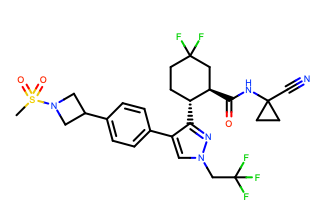
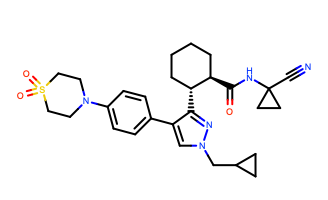
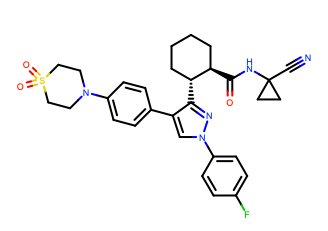
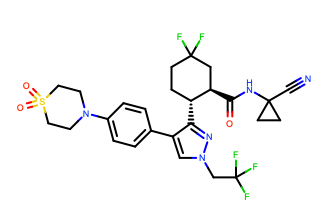
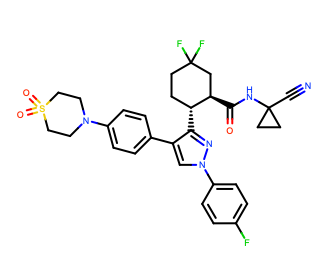

In [2]:
df = oepl.read_sdf("assets/two_series.sdf")
df.tail()

## Step 1: Create Fingerprints

You can use either of the following two methods to create fingerprint series from a molecule series, which use the [OpenEye GraphSim Toolkit](https://docs.eyesopen.com/toolkits/python/graphsimtk/index.html) under-the-hood:

* ```Series.chem.create_fingerprints(...)```: Creates a series of ```OEFingerPrint``` objects. The series has a dtype of ```FingerprintDtype```.
* ```Series.chem.create_numpy_fingerprints(...)```: Creates a series of NumPy boolean array objects. The series has a dtype of ```object```.

The following creates ECFP4-like circular fingerprints as NumPy boolean arrays, convenient for clustering using Scikit-Learn:

Molecule,Title,index,chembl_id,Fingerprint
,,0,CHEMBL4755654,[False False False ... False False False]
,,1,CHEMBL4786857,[False False False ... False False False]
,,2,CHEMBL4791318,[False False False ... False False False]
,,3,CHEMBL1359408,[False False False ... False False False]
,,4,CHEMBL3930223,[False False False ... False False False]

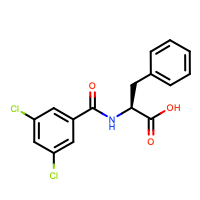
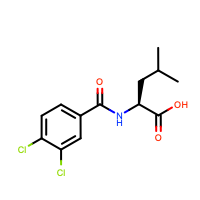
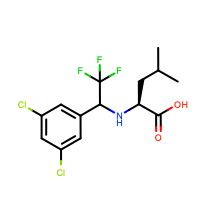
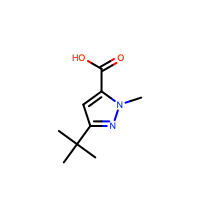
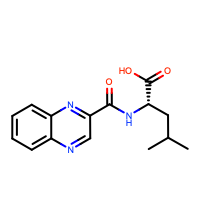

In [3]:
df = df.with_columns(
    df.get_column("Molecule").chem.create_numpy_fingerprints(
        "Circular",  # Path, Tree, LINGO, MACCS
        num_bits=2048, 
        min_distance=0,  # Radius for circular fingerprints
        max_distance=2,  # Radius for circular fingerprints
        atom_type="DefaultCircularAtom",  # Also accepts oegraphsim.OEFPAtomType_ values
        bond_type="DefaultCircularBond"  # Also accepts oegraphsim.OEFPBondType_ values
    ).alias("Fingerprint")
)

df.head()

## Step 2: Molecular Clustering

Let's use the [HDBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html) method to cluster, since it usually does a pretty decent job and requires very little parameterization.

In [4]:
clusterer = HDBSCAN(copy=False)
result = clusterer.fit(df.get_column("Fingerprint").to_list())

# We can inspect the result if we like
result

,"min_cluster_size min_cluster_size: int, default=5The minimum number of samples in a group for that group to beconsidered a cluster; groupings smaller than this size will be leftas noise.",5
,"min_samples min_samples: int, default=NoneThe parameter `k` used to calculate the distance between a point`x_p` and its k-th nearest neighbor.When `None`, defaults to `min_cluster_size`.",None
,"cluster_selection_epsilon cluster_selection_epsilon: float, default=0.0A distance threshold. Clusters below this value will be merged.See [5]_ for more information.",0.0
,"max_cluster_size max_cluster_size: int, default=NoneA limit to the size of clusters returned by the `""eom""` clusterselection algorithm. There is no limit when `max_cluster_size=None`.Has no effect if `cluster_selection_method=""leaf""`.",None
,"metric metric: str or callable, default='euclidean'The metric to use when calculating distance between instances in afeature array.- If metric is a string or callable, it must be one of the options allowed by :func:`~sklearn.metrics.pairwise_distances` for its metric parameter.- If metric is ""precomputed"", X is assumed to be a distance matrix and must be square.",'euclidean'
,"metric_params metric_params: dict, default=NoneArguments passed to the distance metric.",None
,"alpha alpha: float, default=1.0A distance scaling parameter as used in robust single linkage.See [3]_ for more information.",1.0
,"algorithm algorithm: {""auto"", ""brute"", ""kd_tree"", ""ball_tree""}, default=""auto""Exactly which algorithm to use for computing core distances; By defaultthis is set to `""auto""` which attempts to use a:class:`~sklearn.neighbors.KDTree` tree if possible, otherwise it usesa :class:`~sklearn.neighbors.BallTree` tree. Both `""kd_tree""` and`""ball_tree""` algorithms use the:class:`~sklearn.neighbors.NearestNeighbors` estimator.If the `X` passed during `fit` is sparse or `metric` is invalid forboth :class:`~sklearn.neighbors.KDTree` and:class:`~sklearn.neighbors.BallTree`, then it resolves to use the`""brute""` algorithm.",'auto'
,"leaf_size leaf_size: int, default=40Leaf size for trees responsible for fast nearest neighbour queries whena KDTree or a BallTree are used as core-distance algorithms. A largedataset size and small `leaf_size` may induce excessive memory usage.If you are running out of memory consider increasing the `leaf_size`parameter. Ignored for `algorithm=""brute""`.",40
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel to calculate distances.`None` means 1 unless in a :obj:`joblib.parallel_backend` context.`-1` means using all processors. See :term:`Glossary `for more details.",None
,"cluster_selection_method cluster_selection_method: {""eom"", ""leaf""}, default=""eom""The method used to select clusters from the condensed tree. Thestandard approach for HDBSCAN* is to use an Excess of Mass (`""eom""`)algorithm to find the most persistent clusters. Alternatively you caninstead select the clusters at the leaves of the tree -- this providesthe most fine grained and homogeneous clusters.",'eom'


Molecule,Title,index,chembl_id,Fingerprint,Cluster
,,0,CHEMBL4755654,[False False False ... False False False],0
,,1,CHEMBL4786857,[False False False ... False False False],0
,,2,CHEMBL4791318,[False False False ... False False False],0
,,3,CHEMBL1359408,[False False False ... False False False],0
,,4,CHEMBL3930223,[False False False ... False False False],0

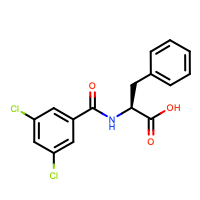
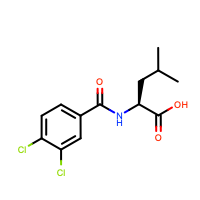
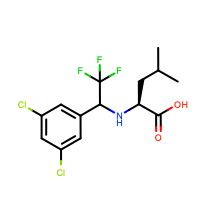
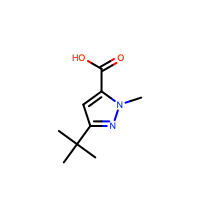
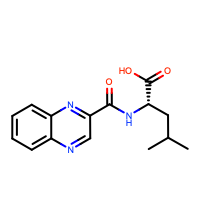

In [5]:
# Assign the cluster labels
df = df.with_columns(
    pl.Series("Cluster", result.labels_)
)

df.head()

# Step 3: Visualize

The best part, let's do some clustering visualization!

**What you should see and try:**

* A "Cluster" box with dropdown. You can select the clusters to visualize (unique values of "Cluster" in the above DataFrame)
* Dismissable pillboxes when you select one or multiple clusters
* If you "Select All" in the "..." menu while filtering on a cluster (or clusters), it will only select from what is filtered.

<div class="alert alert-block alert-info">
<b>NOTE:</b> The grid does not save state between notebook executions. You'll lose your previous selections and filtering state when the notebook is restarted. Remember to save them! It is possible that this will be enabled in a future update.
</div>

In [6]:
# Returns a MolGrid object
grid = df.chem.molgrid(
    "Molecule",
    cluster="Cluster"
)

grid.display()